In [1]:
import dpkt
import os
import pandas as pd
from utils.util import create_directory_if_not_exists, find_files_with_extension
from utils.plotter import plot_siftr_graph


# Convert bytes to Mbit/s
def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

# Read pcap file and get throughput per second for specific ports
def read_pcap(file_path):
    ports = [5101, 5102, 5103, 5106, 8082]
    throughput_per_second = {port: {} for port in ports}
    goodput_per_second = {port: {} for port in ports}
    total_throughput = {port: 0 for port in ports}
    total_goodput = {port: 0 for port in ports}

    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)

        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            l4 = ip.data  # TCP or UDP

            if isinstance(l4, (dpkt.tcp.TCP, dpkt.udp.UDP)):
                dest_port = l4.dport
                if dest_port not in throughput_per_second:
                    continue

                pkt_length = len(buf)
                l4_hdr_len = 0

                # Estimate L4 header length
                if isinstance(l4, dpkt.tcp.TCP):
                    l4_hdr_len = (l4.off * 4)  # TCP offset is in 32-bit words
                elif isinstance(l4, dpkt.udp.UDP):
                    l4_hdr_len = 8  # UDP header is fixed at 8 bytes

                app_payload_len = len(l4.data)

                if start_time is None:
                    start_time = timestamp

                normalized_time = int(timestamp - start_time)

                # Throughput (includes headers)
                if normalized_time not in throughput_per_second[dest_port]:
                    throughput_per_second[dest_port][normalized_time] = pkt_length
                else:
                    throughput_per_second[dest_port][normalized_time] += pkt_length

                # Goodput (payload only)
                if normalized_time not in goodput_per_second[dest_port]:
                    goodput_per_second[dest_port][normalized_time] = app_payload_len
                else:
                    goodput_per_second[dest_port][normalized_time] += app_payload_len

                total_throughput[dest_port] += pkt_length
                total_goodput[dest_port] += app_payload_len

    return throughput_per_second, goodput_per_second, total_throughput, total_goodput


# Plot throughput using plot_siftr_graph
def plot_throughput_with_siftr(file_path, ycolumn, title, xlabel, ylabel, filename, graph_directory, use_goodput=False):
    throughput, goodput, total_thrpt, total_goodpt = read_pcap(file_path)

    
    data_source = goodput if use_goodput else throughput
    total_source = total_goodpt if use_goodput else total_thrpt

    print(total_source.items())

    paths = {}
    print(f"Total {'goodput' if use_goodput else 'throughput'} for {filename}: {total_source}")
    print(data_source.items())

    for port, data in data_source.items():
        if port not in [5101, 5102, 5106]:
            continue
        sorted_data = sorted(data.items())
        times = [item[0] for item in sorted_data]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_data]

        path_df = pd.DataFrame({'Time': times, ycolumn: mbits_transferred})
        path_label = f"Port {port}"
        if port == 5106:
            path_label = "UDP-Prague"
        if port == 5102:
            path_label = "Cubic"

        paths[path_label] = path_df

    create_directory_if_not_exists(graph_directory)
    plot_siftr_graph(paths, ycolumn, title, xlabel, ylabel, filename, graph_directory)


# Main execution
mainpth="../data/udp_data_2025-04-11"
mainpth="../data/udp_data_2025-04-27"
mainpth="../data/udp_net_2025-05-12-10-37-50"
graph_directory = os.path.join(mainpth, "Graphs")
create_directory_if_not_exists(graph_directory)

folderpath = os.path.join(mainpth, "")

# Use the new find_files_with_extension function
filenames, filepaths, file_dict = find_files_with_extension(paths=[folderpath], extension='.pcap')

from utils.thrpt_util import analysis_pcap_tcp

Directory already exists: ../data/udp_net_2025-05-12-10-37-50\Graphs


In [2]:
# # Plot throughput for each pcap file
# for filename, filepath in zip(filenames, filepaths):
#     print(filename)
#     analysis_pcap_tcp(filepath)

In [3]:
filepaths

['../data/udp_net_2025-05-12-10-37-50\\pcap_server_iperf3_d120.pcap']

dict_items([(5101, 0), (5102, 471146708), (5103, 0), (5106, 4403872), (8082, 0)])
Total throughput for pcap_server_iperf3_d120.pcap_throughput: {5101: 0, 5102: 471146708, 5103: 0, 5106: 4403872, 8082: 0}
dict_items([(5101, {}), (5102, {0: 89416409, 1: 555574, 2: 1336726, 3: 420538, 4: 379136, 5: 342012, 6: 57792, 7: 352412, 8: 567058, 9: 1528128, 10: 306468, 11: 830808, 12: 482674, 13: 180748, 14: 711342, 15: 2015634, 16: 2129282, 17: 162844, 18: 246106, 19: 93728, 20: 383864, 21: 1036610, 22: 475434, 23: 88860, 24: 14876, 25: 1394904, 26: 398290, 27: 1735402, 28: 39179240, 29: 561300, 30: 182778, 31: 277030, 32: 1294432, 33: 19286, 34: 339182, 35: 103604, 36: 238408, 37: 124338, 38: 51868, 39: 1408332, 40: 1115226, 41: 510780, 42: 340630, 43: 222282, 44: 152642, 45: 291790, 46: 630906, 47: 727478, 48: 268094, 49: 343658, 50: 385060, 51: 484320, 52: 72536, 53: 226626, 54: 543296, 55: 341946, 56: 902160, 57: 57726, 58: 84384, 59: 288828, 60: 1140172, 61: 2051104, 62: 164358, 63: 399804,

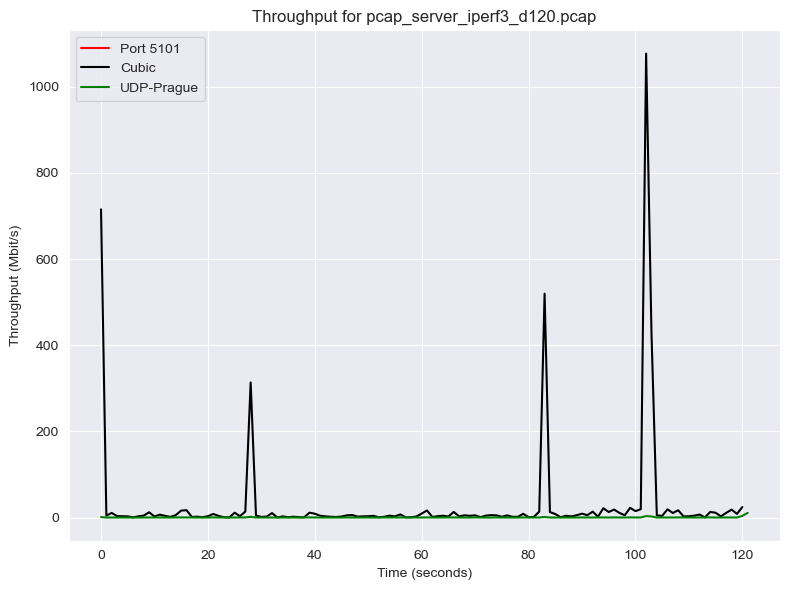

In [4]:
# Plot throughput for each pcap file
for filename, filepath in zip(filenames, filepaths):
    plot_throughput_with_siftr(
        file_path=filepath,
        ycolumn="Throughput (Mbit/s)",
        title=f"Throughput for {filename}",
        xlabel="Time (seconds)",
        ylabel="Throughput (Mbit/s)",
        filename=f"{filename}_throughput",
        graph_directory=graph_directory
    )